In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [4]:
IMAGE_SIZE = 50  # Image dimensions: 50x50 pixels
NUM_OF_CHANNELS = 1  # Grayscale images
TRAIN_DATA_PATH = "american-sign-language-dataset/asl" 

# List of labels (digits and alphabets)
LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
          'a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
          'n','o', 'p', 'q','r', 's', 't','u', 'v', 'w', 'x', 'y', 'z']
NUM_OF_CLASSES = len(LABELS)
NUM_OF_DENSE_LAYER_NODES = 256
print(len(LABELS))

36


In [5]:
#appending image of each type in list
y_unique = []
x_unique = []
for alphabet in os.listdir(TRAIN_DATA_PATH):
    for image in os.listdir(os.path.join(TRAIN_DATA_PATH, alphabet)):
        X = imread(os.path.join(TRAIN_DATA_PATH, alphabet, image))
        x_unique.append(X)
        y_unique.append(alphabet)
        break

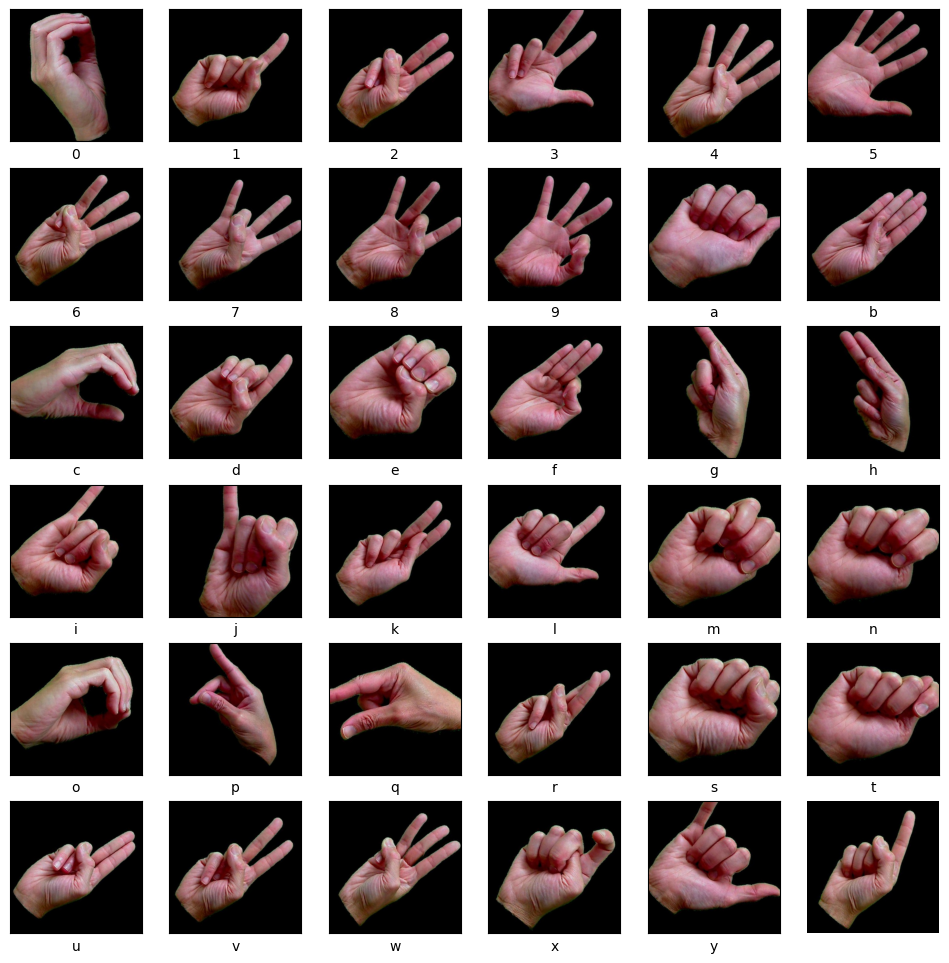

In [6]:
fig=plt.figure(figsize=(12,12))
for i in range(len(x_unique)):
    ax=fig.add_subplot(6,6,i+1)
    ax.imshow(x_unique[i])
    plt.xlabel(y_unique[i])
    plt.xticks([])
    plt.yticks([])
plt.axis('off')
plt.show()
fig.savefig('alphabet')

In [7]:
def create_data(DATA_PATH):
    x=[]
    y=[]
    paths=[]
    for label in LABELS:
        path = os.path.join(DATA_PATH, label)
        label_name = LABELS.index(label)
        for img in os.listdir(path):
            p=os.path.join(path, img)
            try:
                img_array = cv2.imread(p)#os.path.join(path, img))
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
                img_array = cv2.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))
                x.append(img_array)
                y.append(label_name)
            except Exception as e:
                pass
    return x,y

X, y = create_data(TRAIN_DATA_PATH)


In [8]:
NUM_OF_TRAIN_IMAGES = len(X)
print(len(X))

25284


In [9]:
X = np.array(X).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, NUM_OF_CHANNELS)
print(X.shape)

(25284, 50, 50, 1)


In [10]:
X = X.astype("float32") / 255.0 

In [11]:
y = to_categorical(y, num_classes=NUM_OF_CLASSES)  # Ensure correct one-hot encoding


In [12]:
#Saving Data
np.save("X_train.npy", X)
np.save("y_train.npy", y)

In [13]:
X_train=np.load("X_train.npy")
y_train=np.load("y_train.npy")

# Dataset Splitting Strategy

In [30]:
# First, split into train (90%) and test (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# Further split X_train into actual training (90%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
# Print shapes of all dataset splits
print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set shape: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training set shape: X_train: (22755, 50, 50, 1), y_train: (22755, 36)
Validation set shape: X_val: (2529, 50, 50, 1), y_val: (2529, 36)
Test set shape: X_test: (2529, 50, 50, 1), y_test: (2529, 36)


# Data generators

In [15]:
datagen = ImageDataGenerator()
train_generator = datagen.flow(X_train, y_train, batch_size=128)
val_generator   = datagen.flow(X_val, y_val, batch_size=128)

# Creating CNN Model

In [16]:
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.layers import GlobalAveragePooling2D

model = Sequential()

# Augmentation layers
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, NUM_OF_CHANNELS)))
model.add(tf.keras.layers.RandomContrast(factor=0.2))  # Adjust contrast by up to 20%  

# Single convolution block 
model.add(Conv2D(IMAGE_SIZE, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(NUM_OF_DENSE_LAYER_NODES, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(NUM_OF_CLASSES, activation="softmax"))

# Compiling CNN Model

In [17]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_contrast                 │ (None, 50, 50, 1)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 50)     │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 31250)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,000,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,010,008 (30.56 MB)

 Trainable params: 8,010,008 (30.56 MB)

 Non-trainable params: 0 (0.00 B)

# Early Stopping and Learning Rate Reduction

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, verbose=1)

# Training Model

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=10,  # Adjust number of epochs as needed
    callbacks=[early_stop, reduce_lr, checkpoint],
    shuffle=True
)

Epoch 1/10


c:\Web Development\projects\Sign_language_alphabet_recognizer-master\.conda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.3278 - loss: 2.3331
Epoch 1: val_loss improved from inf to 0.60655, saving model to best_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 191ms/step - accuracy: 0.3287 - loss: 2.3293 - val_accuracy: 0.8399 - val_loss: 0.6065 - learning_rate: 0.0010
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7668 - loss: 0.7027
Epoch 2: val_loss improved from 0.60655 to 0.31345, saving model to best_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 201ms/step - accuracy: 0.7670 - loss: 0.7022 - val_accuracy: 0.9209 - val_loss: 0.3134 - learning_rate: 0.0010
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8614 - loss: 0.4113
Epoch 3: val_loss improved from 0.31345 to 0.21335, saving model to best_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.8614 - loss: 0.4112 - val_accuracy: 0.9379 - val_loss: 0.2134 - learning_rate: 0.0010
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy

# Testing the model

 3/20 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

c:\Web Development\projects\Sign_language_alphabet_recognizer-master\.conda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95        77
           1       1.00      0.99      0.99        70
           2       0.96      1.00      0.98        71
           3       1.00      1.00      1.00        82
           4       0.99      0.94      0.96        83
           5       0.94      1.00      0.97        83
           6       0.97      0.97      0.97        66
           7       1.00      0.95      0.98        65
           8       0.97      0.98      0.98        66
           9       1.00      1.00      1.00        74
          10       1.00      0.98      0.99        61
          11       1.00      1.00      1.00        73
          12       1.00      1.00      1.00        74
          13       0.99      1.00      0.99        66
          14       1.00      1.00      1.00        71
          15       1.00      1.00      1.00        69
          16      

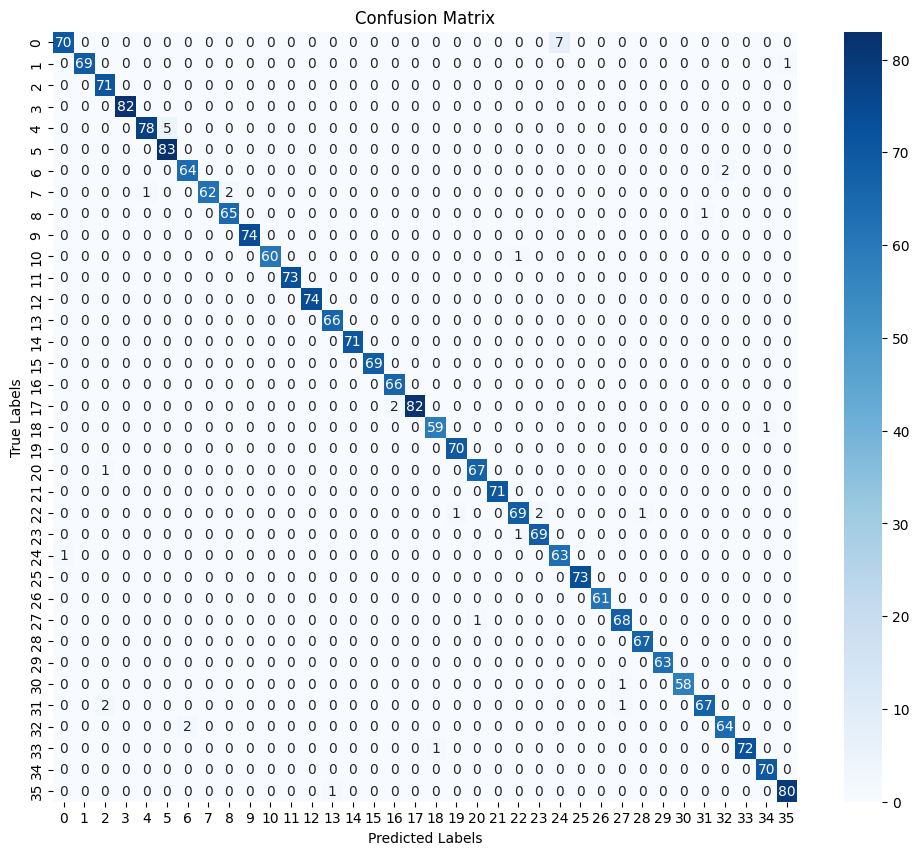

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

# Ensure the test generator does not shuffle data
test_generator = datagen.flow(X_test, y_test, batch_size=128, shuffle=False)

# Get true labels and predictions
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoding to class labels
y_probs = model.predict(test_generator)  # Get probability scores for ROC-AUC
y_pred = np.argmax(y_probs, axis=1)  # Convert probabilities to class labels

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# ROC-AUC Score (One-vs-Rest for multi-class classification)
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(36), yticklabels=range(36))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


# Saving Model for future use

In [22]:
from tensorflow import keras
model.save("model.keras")